In [1]:
# Disable linting for this file
# flake8: noqa
# pylint: skip-file

import cv2
import numpy as np
import pandas as pd
import os
import shutil
from skimage.feature import local_binary_pattern
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score
import seaborn as sns
import matplotlib.pyplot as plt

2025-12-29 09:25:20.112754: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-29 09:25:20.183492: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-29 09:25:21.900076: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
/home/apaiva/.local/lib/python3.11/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


## Separação por Pacientes (evitar viés de dados)
A nomenclatura das imagens segue o padrão `XX_HER2_YYYY.png`, onde `XX` é o ID do paciente.
Para evitar viés, separamos 80% dos pacientes para treino e 20% para validação, garantindo que imagens do mesmo paciente não apareçam em ambos os conjuntos.

**Importante:** Esta separação será usada tanto no Exercício 1 quanto no Exercício 2.

In [7]:
import os
import shutil
import re
from collections import defaultdict

def get_patient_id(filename):
    """Extrai o ID do paciente do nome do arquivo (XX_HER2_YYYY.png)"""
    match = re.match(r'^(\d+)_HER', filename)
    if match:
        return match.group(1)
    return None

def split_by_patient(source_dir, train_dir, val_dir, train_ratio=0.8):
    """
    Separa as imagens em treino e validação por paciente.
    Garante que todas as imagens de um paciente estejam no mesmo conjunto.
    """
    # Limpar diretórios de destino se existirem
    for dir_path in [train_dir, val_dir]:
        if os.path.exists(dir_path):
            shutil.rmtree(dir_path)
    
    # Coletar todos os pacientes e suas imagens por classe
    patients_by_class = defaultdict(lambda: defaultdict(list))
    
    for class_folder in os.listdir(source_dir):
        class_path = os.path.join(source_dir, class_folder)
        if not os.path.isdir(class_path):
            continue
            
        for filename in os.listdir(class_path):
            if filename.endswith(('.png', '.jpg')):
                patient_id = get_patient_id(filename)
                if patient_id:
                    patients_by_class[class_folder][patient_id].append(filename)
    
    # Separar pacientes únicos por classe
    for class_folder, patients in patients_by_class.items():
        patient_ids = list(patients.keys())
        n_train = int(len(patient_ids) * train_ratio)
        
        # Separar pacientes (sem randomização para reprodutibilidade)
        # Ordenar para garantir consistência
        patient_ids_sorted = sorted(patient_ids)
        train_patients = set(patient_ids_sorted[:n_train])
        val_patients = set(patient_ids_sorted[n_train:])
        
        print(f"Classe {class_folder}: {len(train_patients)} pacientes treino, {len(val_patients)} pacientes validação")
        
        # Criar diretórios
        train_class_dir = os.path.join(train_dir, class_folder)
        val_class_dir = os.path.join(val_dir, class_folder)
        os.makedirs(train_class_dir, exist_ok=True)
        os.makedirs(val_class_dir, exist_ok=True)
        
        # Copiar imagens para os respectivos diretórios
        source_class_path = os.path.join(source_dir, class_folder)
        
        for patient_id, files in patients.items():
            if patient_id in train_patients:
                dest_dir = train_class_dir
            else:
                dest_dir = val_class_dir
                
            for filename in files:
                src = os.path.join(source_class_path, filename)
                dst = os.path.join(dest_dir, filename)
                shutil.copy2(src, dst)

# Executar a separação por pacientes
source_dir = '../Train_4cls_amostra'
train_dir = '../Train_4cls_split/train'
val_dir = '../Train_4cls_split/val'

split_by_patient(source_dir, train_dir, val_dir, train_ratio=0.8)
print("\nSeparação por pacientes concluída!")

Classe 3: 4 pacientes treino, 1 pacientes validação
Classe 0: 4 pacientes treino, 1 pacientes validação
Classe 2: 4 pacientes treino, 1 pacientes validação
Classe 1: 4 pacientes treino, 1 pacientes validação

Separação por pacientes concluída!


# Exercicio 1 - Extração Características

### Definição de funções para extração de features usando LBP e VGG16, ler imagens de treino e gerar CSVs

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import pandas as pd

# Função para calcular métricas (suporta multiclasse)
def calculate_metrics_multiclass(y_true, y_pred):
    sensitivity = recall_score(y_true, y_pred, average='macro')
    precision = precision_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    return sensitivity, precision, f1


# Function to extract LBP features
def extract_lbp_features(img_path, radius=3, n_points=24):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    lbp = local_binary_pattern(img, n_points, radius, method='uniform')
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    return hist

# Function to extract VGG16 features
def extract_vgg16_features(img_path):
    base_model = VGG16(weights='imagenet', include_top=False)
    model = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_pool').output)
    
    img = image.load_img(img_path, target_size=(224, 224))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    
    vgg16_features = model.predict(img_data)
    vgg16_features = vgg16_features.flatten()
    return vgg16_features

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [9]:
# Diretório contendo as imagens de TREINO (separadas por paciente)
train_image_dir = '../Train_4cls_split/train'

# Listas para armazenar features e labels
lbp_features_list = []
vgg16_features_list = []
train_labels = []

# Iterar por todas as subpastas (classes) e arquivos
for class_folder in sorted(os.listdir(train_image_dir)):
    class_path = os.path.join(train_image_dir, class_folder)
    if not os.path.isdir(class_path):
        continue
    
    label = int(class_folder)  # Label é o nome da pasta (0, 1, 2, 3)
    
    for filename in os.listdir(class_path):
        if filename.endswith('.png') or filename.endswith('.jpg'):
            img_path = os.path.join(class_path, filename)
            print(f"Processando treino: {filename}")
            
            lbp_features = extract_lbp_features(img_path)
            vgg16_features = extract_vgg16_features(img_path)
            
            lbp_features_list.append(lbp_features)
            vgg16_features_list.append(vgg16_features)
            train_labels.append(label)

# Salvar features de TREINO em CSV
lbp_df = pd.DataFrame(lbp_features_list)
lbp_df['label'] = train_labels
lbp_df.to_csv('lbp_features_train.csv', index=False)

vgg16_df = pd.DataFrame(vgg16_features_list)
vgg16_df['label'] = train_labels
vgg16_df.to_csv('vgg16_features_train.csv', index=False)

print(f"\nTotal de imagens de treino processadas: {len(train_labels)}")

Processando treino: 13_HER2_11396.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
Processando treino: 46_HER2_55795.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
Processando treino: 46_HER2_55339.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
Processando treino: 18_HER2_21645.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
Processando treino: 13_HER2_1259.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
Processando treino: 46_HER2_64186.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
Processando treino: 01_HER2_5357.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
Processando treino: 01_HER2_4163.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
Processando treino: 46_HER2_58500.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
Processando treino: 46_HER2_60084.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
Processando treino: 01_HER2_6435.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
Processando treino: 01_HER2_7841.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
Processando treino: 18_HER2_26007.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
Proc

In [10]:
# Diretório contendo as imagens de VALIDAÇÃO (separadas por paciente)
val_image_dir = '../Train_4cls_split/val'

# Listas para armazenar features e labels de validação
lbp_features_val_list = []
vgg16_features_val_list = []
val_labels = []

# Iterar por todas as subpastas (classes) e arquivos
for class_folder in sorted(os.listdir(val_image_dir)):
    class_path = os.path.join(val_image_dir, class_folder)
    if not os.path.isdir(class_path):
        continue
    
    label = int(class_folder)
    
    for filename in os.listdir(class_path):
        if filename.endswith('.png') or filename.endswith('.jpg'):
            img_path = os.path.join(class_path, filename)
            print(f"Processando validação: {filename}")
            
            lbp_features = extract_lbp_features(img_path)
            vgg16_features = extract_vgg16_features(img_path)
            
            lbp_features_val_list.append(lbp_features)
            vgg16_features_val_list.append(vgg16_features)
            val_labels.append(label)

# Salvar features de VALIDAÇÃO em CSV
lbp_val_df = pd.DataFrame(lbp_features_val_list)
lbp_val_df['label'] = val_labels
lbp_val_df.to_csv('lbp_features_val.csv', index=False)

vgg16_val_df = pd.DataFrame(vgg16_features_val_list)
vgg16_val_df['label'] = val_labels
vgg16_val_df.to_csv('vgg16_features_val.csv', index=False)

print(f"\nTotal de imagens de validação processadas: {len(val_labels)}")

Processando validação: 57_HER2_11431.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
Processando validação: 57_HER2_6823.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
Processando validação: 57_HER2_13564.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
Processando validação: 57_HER2_5380.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
Processando validação: 57_HER2_12145.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
Processando validação: 57_HER2_12845.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
Processando validação: 57_HER2_11189.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
Processando validação: 57_HER2_4660.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
Processando validação: 57_HER2_4420.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
Processando validação: 57_HER2_12152.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
Processando validação: 57_HER2_12383.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
Processando validação: 57_HER2_12381.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
Processando validação: 57_HER2_13324.png
1/1

### Treinar modelos em RandomForest, SVM e RNA

In [15]:
# Carregar features de TREINO
lbp_train_df = pd.read_csv('lbp_features_train.csv')
vgg16_train_df = pd.read_csv('vgg16_features_train.csv')

# Separar labels
train_labels = lbp_train_df['label'].values
lbp_train_features = lbp_train_df.drop('label', axis=1)
vgg16_train_features = vgg16_train_df.drop('label', axis=1)

# Combinar features
combined_train_features = pd.concat([lbp_train_features, vgg16_train_features], axis=1)

# Treinar Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(combined_train_features, train_labels)

# Treinar SVM Classifier
svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(combined_train_features, train_labels)

# Treinar MLP Classifier
mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
mlp_model.fit(combined_train_features, train_labels)

print("Modelos treinados com sucesso!")

Modelos treinados com sucesso!


### Avaliar modelos no conjunto de Validação (separado por pacientes)

=== Métricas no conjunto de VALIDAÇÃO (separado por pacientes) ===

Random Forest - Sensitivity: 0.7083, Precision: 0.7138, F1-Score: 0.6845
SVM - Sensitivity: 0.5667, Precision: 0.5807, F1-Score: 0.5655
MLP - Sensitivity: 0.8333, Precision: 0.8642, F1-Score: 0.8228


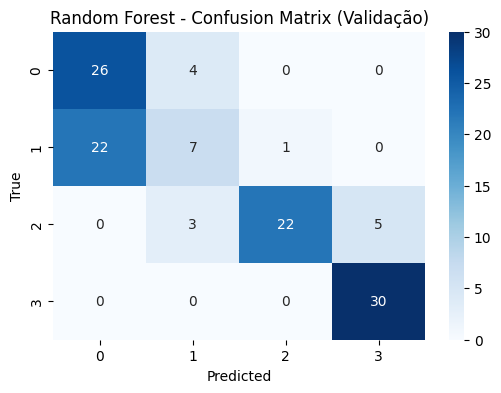

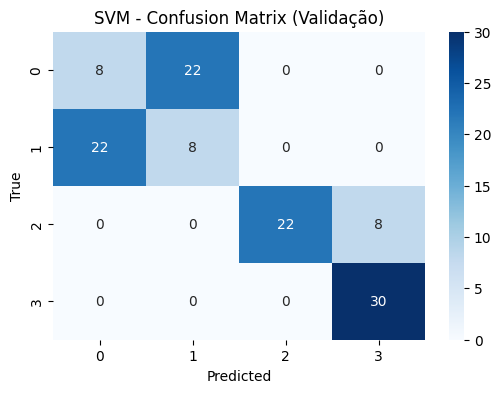

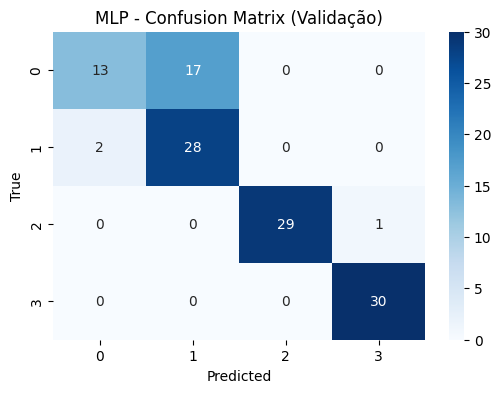

In [ ]:
# Carregar features de VALIDAÇÃO
lbp_val_df = pd.read_csv('lbp_features_val.csv')
vgg16_val_df = pd.read_csv('vgg16_features_val.csv')

# Separar labels
val_labels = lbp_val_df['label'].values
lbp_val_features = lbp_val_df.drop('label', axis=1)
vgg16_val_features = vgg16_val_df.drop('label', axis=1)

# Combinar features de validação
combined_val_features = pd.concat([lbp_val_features, vgg16_val_features], axis=1)

# Aplicar modelo Random Forest
rf_val_predictions = rf_model.predict(combined_val_features)
rf_val_sensitivity, rf_val_precision, rf_val_f1 = calculate_metrics_multiclass(val_labels, rf_val_predictions)

# Aplicar modelo SVM
svm_val_predictions = svm_model.predict(combined_val_features)
svm_val_sensitivity, svm_val_precision, svm_val_f1 = calculate_metrics_multiclass(val_labels, svm_val_predictions)

# Aplicar modelo MLP
mlp_val_predictions = mlp_model.predict(combined_val_features)
mlp_val_sensitivity, mlp_val_precision, mlp_val_f1 = calculate_metrics_multiclass(val_labels, mlp_val_predictions)

# Imprimir métricas de validação
print("=== Métricas no conjunto de VALIDAÇÃO ===\n")
print(f"Random Forest - Sensitivity: {rf_val_sensitivity:.4f}, Precision: {rf_val_precision:.4f}, F1-Score: {rf_val_f1:.4f}")
print(f"SVM - Sensitivity: {svm_val_sensitivity:.4f}, Precision: {svm_val_precision:.4f}, F1-Score: {svm_val_f1:.4f}")
print(f"MLP - Sensitivity: {mlp_val_sensitivity:.4f}, Precision: {mlp_val_precision:.4f}, F1-Score: {mlp_val_f1:.4f}")

# Plotar matrizes de confusão
plot_confusion_matrix(val_labels, rf_val_predictions, 'Random Forest - Confusion Matrix (Validação)')
plot_confusion_matrix(val_labels, svm_val_predictions, 'SVM - Confusion Matrix (Validação)')
plot_confusion_matrix(val_labels, mlp_val_predictions, 'MLP - Confusion Matrix (Validação)')

# Exercício 2 - Redes Neurais

### Gerar bases para treinamento e validação (usando separação por pacientes)

In [19]:
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score
import numpy as np

# Define image size and batch size
image_size = (224, 224)
batch_size = 32

# Data generators for VGG16 (com preprocessing específico da rede)
train_datagen_vgg16 = ImageDataGenerator(preprocessing_function=vgg16_preprocess)
val_datagen_vgg16 = ImageDataGenerator(preprocessing_function=vgg16_preprocess)
test_datagen_vgg16 = ImageDataGenerator(preprocessing_function=vgg16_preprocess)

# Data generators for ResNet50 (com preprocessing específico da rede)
train_datagen_resnet50 = ImageDataGenerator(preprocessing_function=resnet50_preprocess)
val_datagen_resnet50 = ImageDataGenerator(preprocessing_function=resnet50_preprocess)
test_datagen_resnet50 = ImageDataGenerator(preprocessing_function=resnet50_preprocess)

# Generators para VGG16
train_generator_vgg16 = train_datagen_vgg16.flow_from_directory(
    '../Train_4cls_split/train',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator_vgg16 = val_datagen_vgg16.flow_from_directory(
    '../Train_4cls_split/val',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator_vgg16 = test_datagen_vgg16.flow_from_directory(
    '../Test_4cl_amostra',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Generators para ResNet50
train_generator_resnet50 = train_datagen_resnet50.flow_from_directory(
    '../Train_4cls_split/train',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator_resnet50 = val_datagen_resnet50.flow_from_directory(
    '../Train_4cls_split/val',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator_resnet50 = test_datagen_resnet50.flow_from_directory(
    '../Test_4cl_amostra',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

print(f"\nImagens de treino: {train_generator_vgg16.samples}")
print(f"Imagens de validação: {validation_generator_vgg16.samples}")
print(f"Imagens de teste: {test_generator_vgg16.samples}")

Found 473 images belonging to 4 classes.
Found 120 images belonging to 4 classes.
Found 371 images belonging to 4 classes.
Found 473 images belonging to 4 classes.
Found 120 images belonging to 4 classes.
Found 371 images belonging to 4 classes.

Imagens de treino: 473
Imagens de validação: 120
Imagens de teste: 371


### Treinar modelos e validar (sem augmentation)

In [20]:
# Function to create a model with transfer learning
def create_model(base_model, num_classes):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    
    for layer in base_model.layers:
        layer.trainable = False
    
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create VGG16 and ResNet50 base models
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet50_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Create models
num_classes = train_generator_vgg16.num_classes
vgg16_model = create_model(vgg16_base, num_classes)
resnet50_model = create_model(resnet50_base, num_classes)

# Train VGG16 model (sem augmentation)
print("Treinando VGG16 sem augmentation...")
vgg16_model.fit(train_generator_vgg16, validation_data=validation_generator_vgg16, epochs=10)

# Train ResNet50 model (sem augmentation)
print("\nTreinando ResNet50 sem augmentation...")
resnet50_model.fit(train_generator_resnet50, validation_data=validation_generator_resnet50, epochs=10)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step
Treinando VGG16 sem augmentation...
Epoch 1/10


2025-12-29 11:09:09.323911: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 411041792 exceeds 10% of free system memory.
2025-12-29 11:09:09.389191: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 411041792 exceeds 10% of free system memory.
2025-12-29 11:09:09.834344: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 102760448 exceeds 10% of free system memory.
2025-12-29 11:09:09.904849: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 205520896 exceeds 10% of free system memory.
2025-12-29 11:09:10.110676: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 205520896 exceeds 10% of free system memory.


15/15 ━━━━━━━━━━━━━━━━━━━━ 81s 5s/step - accuracy: 0.7970 - loss: 0.5922 - val_accuracy: 0.7917 - val_loss: 0.9386
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 84s 6s/step - accuracy: 0.9514 - loss: 0.1069 - val_accuracy: 0.7917 - val_loss: 0.9943
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 92s 6s/step - accuracy: 0.9894 - loss: 0.0335 - val_accuracy: 0.9000 - val_loss: 0.5896
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 96s 7s/step - accuracy: 1.0000 - loss: 0.0058 - val_accuracy: 0.9250 - val_loss: 0.4219
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 95s 6s/step - accuracy: 1.0000 - loss: 0.0031 - val_accuracy: 0.9250 - val_loss: 0.4377
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 100s 7s/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 0.9250 - val_loss: 0.4626
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 101s 7s/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 0.9250 - val_loss: 0.4594
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 104s 7s/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 0.9250 - val_loss: 0.4505


### Gerar dados com Augmentation e treinar e validar na base de treinamento

In [21]:
# Data generators with data augmentation para VGG16
# Removido: shear_range e zoom_range (deformam a imagem e alteram tamanhos das células)
train_datagen_vgg16_aug = ImageDataGenerator(
    preprocessing_function=vgg16_preprocess,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Data generators with data augmentation para ResNet50
train_datagen_resnet50_aug = ImageDataGenerator(
    preprocessing_function=resnet50_preprocess,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generators de treino com augmentation
train_generator_vgg16_aug = train_datagen_vgg16_aug.flow_from_directory(
    '../Train_4cls_split/train',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

train_generator_resnet50_aug = train_datagen_resnet50_aug.flow_from_directory(
    '../Train_4cls_split/train',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Criar novos modelos para treino com augmentation
vgg16_base_aug = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet50_base_aug = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

vgg16_model_aug = create_model(vgg16_base_aug, num_classes)
resnet50_model_aug = create_model(resnet50_base_aug, num_classes)

# Train VGG16 model with augmentation
print("Treinando VGG16 com augmentation...")
vgg16_model_aug.fit(train_generator_vgg16_aug, validation_data=validation_generator_vgg16, epochs=10)

# Train ResNet50 model with augmentation
print("\nTreinando ResNet50 com augmentation...")
resnet50_model_aug.fit(train_generator_resnet50_aug, validation_data=validation_generator_resnet50, epochs=10)

Found 473 images belonging to 4 classes.
Found 473 images belonging to 4 classes.
Treinando VGG16 com augmentation...
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 107s 7s/step - accuracy: 0.6575 - loss: 1.5873 - val_accuracy: 0.7167 - val_loss: 2.2717
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 90s 6s/step - accuracy: 0.8964 - loss: 0.2800 - val_accuracy: 0.7250 - val_loss: 1.0607
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 89s 6s/step - accuracy: 0.9323 - loss: 0.1872 - val_accuracy: 0.8500 - val_loss: 0.5006
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 89s 6s/step - accuracy: 0.9450 - loss: 0.1299 - val_accuracy: 0.8417 - val_loss: 0.5220
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 89s 6s/step - accuracy: 0.9767 - loss: 0.0688 - val_accuracy: 0.8083 - val_loss: 0.6484
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 90s 6s/step - accuracy: 0.9767 - loss: 0.0763 - val_accuracy: 0.8250 - val_loss: 0.6325
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 95s 6s/step - accuracy: 0.9704 - loss: 0.0881 - val_accuracy: 0.9250 - val_loss: 0.3483

### Extrair métricas e imprimir

12/12 ━━━━━━━━━━━━━━━━━━━━ 45s 4s/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 51s 4s/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step
=== Métricas no conjunto de TESTE ===

Sem Augmentation:
VGG16 - Sensitivity: 0.8234, Precision: 0.8274, F1-Score: 0.8158
ResNet50 - Sensitivity: 0.9114, Precision: 0.9108, F1-Score: 0.9105

Com Augmentation:
VGG16 - Sensitivity: 0.8207, Precision: 0.8270, F1-Score: 0.8114
ResNet50 - Sensitivity: 0.9222, Precision: 0.9272, F1-Score: 0.9205

=== Matrizes de Confusão ===


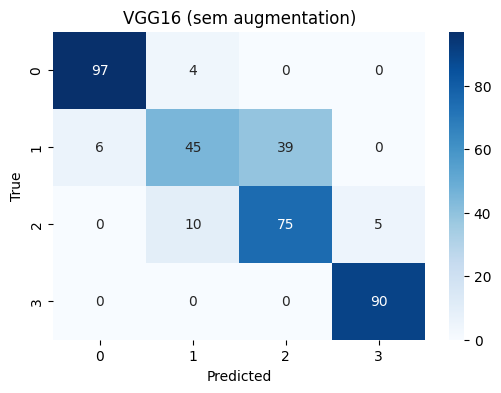

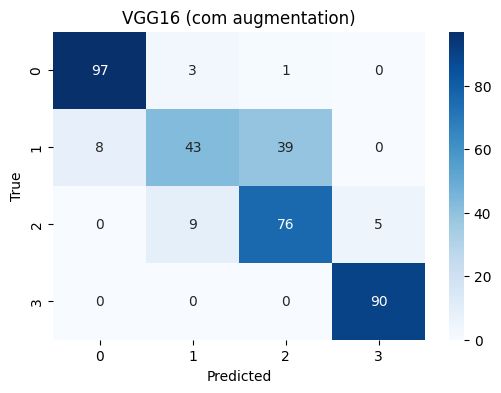

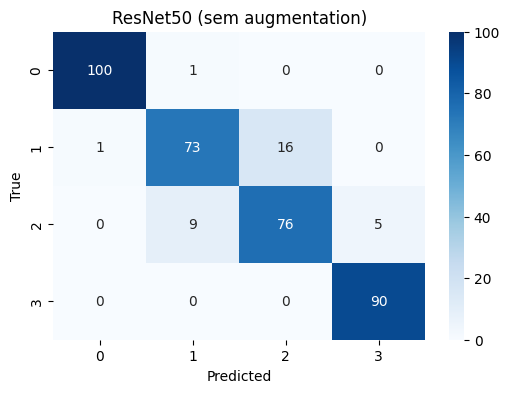

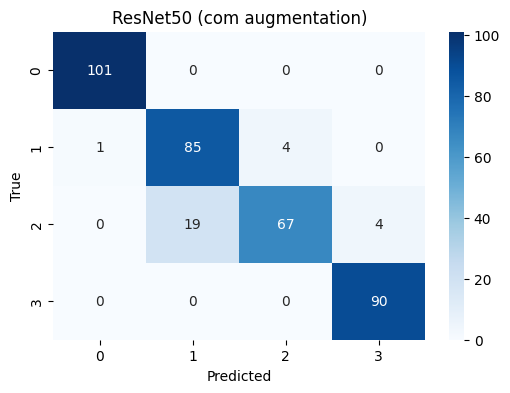

In [22]:
# Function to evaluate model
def evaluate_model(model, test_generator):
    test_generator.reset()
    predictions = model.predict(test_generator)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_generator.classes
    
    sensitivity = recall_score(y_true, y_pred, average='macro')
    precision = precision_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    
    return sensitivity, precision, f1, y_true, y_pred

# Evaluate VGG16 models (usando test_generator com preprocess_input correto)
vgg16_sensitivity, vgg16_precision, vgg16_f1, y_true_vgg, y_pred_vgg = evaluate_model(vgg16_model, test_generator_vgg16)
vgg16_aug_sensitivity, vgg16_aug_precision, vgg16_aug_f1, _, y_pred_vgg_aug = evaluate_model(vgg16_model_aug, test_generator_vgg16)

# Evaluate ResNet50 models (usando test_generator com preprocess_input correto)
resnet50_sensitivity, resnet50_precision, resnet50_f1, y_true_resnet, y_pred_resnet = evaluate_model(resnet50_model, test_generator_resnet50)
resnet50_aug_sensitivity, resnet50_aug_precision, resnet50_aug_f1, _, y_pred_resnet_aug = evaluate_model(resnet50_model_aug, test_generator_resnet50)

# Print the metrics
print("=== Métricas no conjunto de TESTE ===\n")
print("Sem Augmentation:")
print(f"VGG16 - Sensitivity: {vgg16_sensitivity:.4f}, Precision: {vgg16_precision:.4f}, F1-Score: {vgg16_f1:.4f}")
print(f"ResNet50 - Sensitivity: {resnet50_sensitivity:.4f}, Precision: {resnet50_precision:.4f}, F1-Score: {resnet50_f1:.4f}")

print("\nCom Augmentation:")
print(f"VGG16 - Sensitivity: {vgg16_aug_sensitivity:.4f}, Precision: {vgg16_aug_precision:.4f}, F1-Score: {vgg16_aug_f1:.4f}")
print(f"ResNet50 - Sensitivity: {resnet50_aug_sensitivity:.4f}, Precision: {resnet50_aug_precision:.4f}, F1-Score: {resnet50_aug_f1:.4f}")

# Plot confusion matrices
print("\n=== Matrizes de Confusão ===")
plot_confusion_matrix(y_true_vgg, y_pred_vgg, 'VGG16 (sem augmentation)')
plot_confusion_matrix(y_true_vgg, y_pred_vgg_aug, 'VGG16 (com augmentation)')
plot_confusion_matrix(y_true_resnet, y_pred_resnet, 'ResNet50 (sem augmentation)')
plot_confusion_matrix(y_true_resnet, y_pred_resnet_aug, 'ResNet50 (com augmentation)')